In exploration phase there is always balance between making code easy to change and on other hand produciton ready. 

In notebooks I go with make it easy to understand and change, and we would optimise it later when we are satisfied with model results.

One of this tradeoffs is I keep functions and some imports close to cell I use them first time, for easy of testing and change. Idealy I would move them right after initial imports or even separate file. 


We will use `DEVELOPMENT` variable to skip some cells without commenting them out.

In [70]:
DEVELOPMENT = True

In [2]:
import pandas as pd
from pathlib import Path
import sqlite3
from datetime import datetime
import traceback
import dtale
import re
import math
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns 

# Checkouts

Load checkouts table, explore and clean the data.

In [3]:
checkouts_df = pd.read_csv('data/checkouts.csv')

In [4]:
checkouts_df.head(2)

,id,patron_id,library_id,date_checkout,date_returned
0,-xFj0vTLbRIC,b071c9c68228a2b1d00e6f53677e16da,225-222@5xc-jtz-hkf,2019-01-28,2018-11-13
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12


In [5]:
checkouts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2000 non-null   object
 1   patron_id      2000 non-null   object
 2   library_id     2000 non-null   object
 3   date_checkout  1935 non-null   object
 4   date_returned  1942 non-null   object
dtypes: object(5)
memory usage: 78.3+ KB


Since PDF with assigment has been created 2021-04-09, and dataset has no 2021 and 2017 in it, I will use those as cutoff dates.

In [6]:
checkouts_df["date_returned"] = checkouts_df["date_returned"].fillna('')
checkouts_df[checkouts_df["date_returned"].str.contains('2021')]


,id,patron_id,library_id,date_checkout,date_returned


In [7]:
checkouts_df["date_checkout"] = checkouts_df["date_checkout"].fillna('')
checkouts_df[checkouts_df["date_checkout"].str.contains('2021')]

,id,patron_id,library_id,date_checkout,date_returned


In [8]:
checkouts_df = pd.read_csv('data/checkouts.csv')

In [10]:
checkouts_df["date_checkout"] = checkouts_df["date_checkout"].fillna('2017-12-31') # this is bad data
checkouts_df["date_returned"] = checkouts_df["date_returned"].fillna('2021-04-09') # not yet returned or bad data

We have many different date formats, dates in the past, dates in the future. This would prompt me to get in touch with aplicaiton developers to implement data verification on data entry form. This is not only affecting our analisys, but work of the libraries.  

In [11]:
date_formats = ["%Y-%m-%d", "%Y/%m/%d" , "%Y%m%d", "%Y|%m|%d", "%Y %m %d", "%Y", "%Y-%m"]

def is_valid_date(date_str:str, formats:str):
    """
    Function to convertd different string dates to datetime. 
    
    """
    date_str = date_str.replace('%', '')
    date_str = date_str.strip()

    for fmt in formats:
        try:
            # Try to parse the date with the current format
            return datetime.strptime(date_str, fmt)
        except Exception as e:

            continue
    print(date_str)
    return None 


# Apply the function to check validity of each date
checkouts_df["date_checkout"] = checkouts_df["date_checkout"].apply(lambda x: is_valid_date(x, date_formats))
checkouts_df["date_returned"] = checkouts_df["date_returned"].apply(lambda x: is_valid_date(x, date_formats))

'`length`' will be "lenght patron had the book rented"

In [12]:
checkouts_df['length'] = checkouts_df.date_returned - checkouts_df.date_checkout
checkouts_df['length'] = checkouts_df.length.dt.days

`date_checkout` before 2018-01-01 are all 1800 and invalid, including 2017-12-31 which is N/A. Let's see how many of those rows we have and filter them out:

In [13]:
checkouts_df[checkouts_df.date_checkout<='2017-12-31'].shape 

(155, 6)

In [14]:
checkouts_df = checkouts_df[checkouts_df.date_checkout>'2017-12-31']

loans retruned after 2021-04-09 are illegal dates, not contributing to our analisys

In [1005]:
checkouts_df[checkouts_df.date_returned>'2021-04-09'].shape

(95, 6)

And let's see how many wrong dates are for `date_return` and remove those rows too:

In [20]:
checkouts_df[checkouts_df.date_returned>'2021-04-09'].shape

(95, 6)

In [21]:
checkouts_df = checkouts_df[checkouts_df.date_returned<='2021-04-09']

Negative `length` (duration) of rent tells us something is wrong with those dates and we can not fix them:

In [23]:
checkouts_df[checkouts_df.length<0].shape

(241, 6)

In [24]:
checkouts_df = checkouts_df[~checkouts_df.length<0]

How many of clean checkouts we have with books returned on time:

In [25]:
checkouts_df[checkouts_df.length<=28].shape

(1319, 6)

and how many were late:

In [26]:
checkouts_df[checkouts_df.length>28].shape

(190, 6)

As expected, this is inbalanced dataset, we neet to be careful with that.

<Axes: >

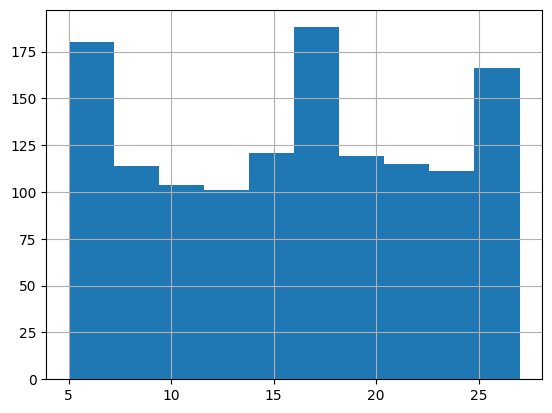

In [27]:
checkouts_df[checkouts_df.length<=28].length.hist()

Data looks sythetic, I would expect  Poisson Probability Distribution here, while this is more uniform, let's see further. Maybe 28 day cutoff is affecting distribution.

<Axes: >

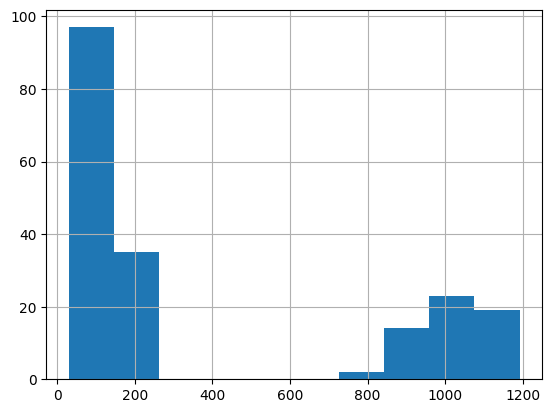

In [28]:
checkouts_df[checkouts_df.length>28].length.hist()

Late returns distribution is affected by choosing 2019-03-09 as retrun date which is too much, but right now we don't know better.

Let's save data, just in case.

In [29]:
checkouts_df.to_csv('data/checkouts_df_clean.csv')

In [30]:
checkouts_df.to_pickle('data/checkouts_df.pickle')

In [31]:
checkouts_df = pd.read_pickle('data/checkouts_df.pickle')

In [32]:
checkouts_df.head(2)

,id,patron_id,library_id,date_checkout,date_returned,length
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14
2,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,62


# Books

Load, explore and clean books table.

In [38]:
books_df = pd.read_csv('data/books.csv').add_prefix('book_')

In [39]:
books_df.columns

Index(['book_id', 'book_title', 'book_authors', 'book_publisher',
       'book_publishedDate', 'book_categories', 'book_price', 'book_pages'],
      dtype='object')

In [40]:
def clean_price(price: str) -> float:
    """
    Clean price, leave only float number an remove other characters.
    
    """
    cleaned = re.sub(r"[^\d\.-]", "", price)
    # Ensure valid float format by checking if it can be converted
    try:
        return float(cleaned)
    except ValueError:
        return None


def clean_page_count(page_count: str):
    """
    Clean page count number, leave only positive integers.
    """
    cleaned = re.sub(r"[^\d]", "", page_count)
    # Ensure valid integer format by checking if it's non-empty
    try:
        return int(cleaned) if cleaned else None
    except ValueError:
        return None


This is a bit directd after exploring book table, there are books with no author data, no publisher data or even published date, some don't have categories or price. 
Date formats are also confusing, another call to developers to push that ticket for input data validation higher up.



In [41]:
books_df['book_authors'] = books_df['book_authors'].fillna("['NO_AUTHOR']")
books_df['book_publisher'] = books_df['book_publisher'].fillna("['NO_PUBLISHER']")
books_df['book_publishedDate'] = books_df['book_publishedDate'].fillna('2021-04-09')

date_formats = ["%Y-%m-%d", "%Y", "%Y-%m"] 
books_df['book_publishedDate'] = books_df['book_publishedDate'].apply(lambda x: is_valid_date(x, date_formats))
books_df['book_published_year'] = books_df.book_publishedDate.dt.year

books_df['book_categories'] = books_df['book_categories'].fillna("['NO_CATEGORY']")

books_df["book_price"] = books_df["book_price"].fillna("0.0")
books_df["book_price"] = books_df.book_price.apply(lambda x: clean_price(x))

books_df["book_pages"] = books_df.book_pages.apply(lambda x: clean_page_count(x))

In [42]:
books_df.head(2)

,book_id,book_title,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,book_published_year
0,hVFwAAAAQBAJ,Ogilvy on Advertising,['David Ogilvy'],Vintage,2013-09-11,['Social Science'],72.99,320,2013
1,bRY9AAAAYAAJ,Foreign Publications for Advertising American ...,['United States. Bureau of Foreign and Domesti...,['NO_PUBLISHER'],1913-01-01,['Advertising'],469.99,654,1913


# Customers

Load explore and clean customers data.

Customer data has more diverse data than above. There is address in it, we will use it to find GPS coordinates of patrons which might help with prediciton. Maybe some parts of the city are more often late than others.  We will use public open street map  service which we should respect and not over use. Maximum rate is 1 request per second and don't repeat the requests. For that reason I have created notebook `address_to_gps.ipynb` only for that purpose, since in exploration phase I needed a lot of repeats. In case we would implement this in the production we would use paid or self hosted version.  Cached data is stored in pickle `data/coordinates_list_gdf.pickle`.


Zip code, city and state data required another call to developers and I added those fields to the initial ticket about user input. I think they are starting to understand the problem. 

In [50]:
customers_df = pd.read_csv('data/customers.csv').add_prefix('customer_')

In [51]:
from geopy.geocoders import Nominatim
import time
from shapely import Point

geolocator = Nominatim(user_agent="marko@droopia")


def get_gps_coordinates(address: str, geolocator=geolocator) -> Point:
    """
    Get GPS coordindates for given addresses.
    """

    time.sleep(1.1)
    location = geolocator.geocode(address)
    if location:
        return Point(location.longitude, location.latitude)
    else:
        return None


def clean_state(state):
    try:
        return state.upper().strip()
    except ValueError:
        return None


def clean_zipcode(zipcode):
    cleaned = re.sub(r"[^\d\.]", "", zipcode)
    try:
        return math.floor(float(cleaned))
    except ValueError:
        return None

There are empty city, state and zip code cells. Let's see if we can find out those values based on other data. 



In [52]:
customers_df["customer_state"] = customers_df.customer_state.fillna('N/A')
customers_df["customer_state"] = customers_df.customer_state.apply(lambda x: clean_state(x))

In [53]:
customers_df["customer_city"] = customers_df.customer_city.fillna('N/A')
customers_df["customer_city"] = customers_df.customer_city.apply(lambda x: clean_state(x))

ex. zipcode should be the same for the same street. 

In [54]:
customers_df[customers_df.customer_zipcode.isna()]

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation
1728,21d1bb3a22811b8d490076e81288dfdb,Kendrick Luciano,822 SE Main St,PORTLAND,OREGON,NaN,2109-06-22,male,Others,Admin & Support


In [55]:
customers_df[customers_df.customer_street_address.str.contains('SE Main St')]

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation
432,e4dbbc3721bbb685c5164fde6d6d03b2,Steven Sims,9600 SE Main St,PORTLAND,OREGON,97222.0,1997-08-14,male,College,Education & Health
1425,1152955d888f69ca5e76967d975d46b6,William Crites,9316 SE Main St,N/A,OREGON,97222.0,1969-06-27,male,GRADUATE Degree,Sales
1446,251926625070cc0d3e1d5cdafc333f45,Brittany Jones,12802 SE Main St,PORTLAND,OREGON,97233.0,1981-11-23,female,High School,Others
1497,22e42e5a878a0515ad7cad82ff6ae197,Virginia Watson,833 SE Main St,PORTLAND,OREGON,97214.0,1958-01-06,female,Graduate Degree,Others
1586,57650bbd8b2029e1b670ef543312411c,Harry Nelson,3002 SE Main St,PORTLAND,OREGON,97214.0,1986-04-09,male,College,blue COLLAR
1728,21d1bb3a22811b8d490076e81288dfdb,Kendrick Luciano,822 SE Main St,PORTLAND,OREGON,NaN,2109-06-22,male,Others,Admin & Support


In [56]:
customers_df.loc[customers_df.customer_zipcode.isna(), 'customer_zipcode'] = '97214.0'

In [57]:
# customers_df["customer_zipcode"] = customers_df.customer_zipcode.fillna('0')
customers_df["customer_zipcode"] = customers_df.customer_zipcode.apply(lambda x: clean_zipcode(x))

Dates are as bad as we expected by now. We will also create new feature how old is patron.

In [1108]:
date_formats = ["%Y-%m-%d", "%Y/%m/%d" , "%Y%m%d", "%Y|%m|%d", "%Y %m %d", "%Y", "%Y-%m"]
customers_df["customer_birth_date"] = customers_df["customer_birth_date"].fillna('2021-04-09')

customers_df["customer_birth_date"] = customers_df["customer_birth_date"].apply(lambda x: is_valid_date(x, date_formats))

# this will make mistake for leap years, but this is good enough for current needs
customers_df["customer_years_old"] = (pd.to_datetime('2021-04-09') - customers_df["customer_birth_date"]).dt.days/365.2425 
customers_df["customer_years_old"] = customers_df["customer_years_old"].astype(int)

In [58]:
customers_df['customer_gender'] = customers_df.customer_gender.fillna('NA')
customers_df['customer_gender'] = customers_df.customer_gender.apply(lambda x: clean_state(x))

In [59]:
customers_df.customer_gender.unique()

array(['FEMALE', 'MALE', 'NA'], dtype=object)

In [60]:
customers_df[customers_df.customer_gender=='NA'].shape

(101, 10)

In [61]:
customers_df['customer_education'] = customers_df.customer_education.fillna('NA')
customers_df['customer_education'] = customers_df.customer_education.apply(lambda x: clean_state(x))
customers_df['customer_education'] = customers_df.customer_education.apply(lambda x: x.replace(' ', '').replace('   ', '').replace('  ', ''))

In [62]:
customers_df.customer_education.unique()

array(['HIGHSCHOOL', 'COLLEGE', 'GRADUATEDEGREE', 'OTHERS', 'NA'],
      dtype=object)

In [63]:
customers_df[customers_df.customer_education=='NA'].shape

(104, 10)

In [64]:
customers_df['customer_occupation'] = customers_df.customer_occupation.fillna('NA')
customers_df['customer_occupation'] = customers_df.customer_occupation.apply(lambda x: clean_state(x))
customers_df['customer_occupation'] = customers_df.customer_occupation.apply(lambda x: x.replace(' ', '').replace('   ', '').replace('  ', ''))

In [65]:
customers_df.customer_occupation.unique()

array(['NA', 'BLUECOLLAR', 'EDUCATION&HEALTH', 'SALES', 'TECH', 'OTHERS',
       'BUSINESS&FINANCE', 'ADMIN&SUPPORT'], dtype=object)

In [66]:
customers_df['customer_street_address'] = customers_df.customer_street_address.apply(lambda x: clean_state(x))

In [68]:
customers_df.shape

(2000, 10)

We will not use the next easy-to-use line, but we will use cached version made in `address_to_gps.ipynb` for all cleaned addreses.

In [71]:
if not DEVELOPMENT:
    customers_df["geometry"]  = customers_df["address"].apply(lambda x: get_gps_coordinates(x))

In [72]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   customer_id              2000 non-null   object
 1   customer_name            2000 non-null   object
 2   customer_street_address  2000 non-null   object
 3   customer_city            2000 non-null   object
 4   customer_state           2000 non-null   object
 5   customer_zipcode         2000 non-null   int64 
 6   customer_birth_date      1893 non-null   object
 7   customer_gender          2000 non-null   object
 8   customer_education       2000 non-null   object
 9   customer_occupation      2000 non-null   object
dtypes: int64(1), object(9)
memory usage: 156.4+ KB


In [73]:
customers_df.columns

Index(['customer_id', 'customer_name', 'customer_street_address',
       'customer_city', 'customer_state', 'customer_zipcode',
       'customer_birth_date', 'customer_gender', 'customer_education',
       'customer_occupation'],
      dtype='object')

`customer_state` and `customer_city` require a bit of exploration and fixing:

In [74]:
customers_df.customer_state.unique()

array(['OREGON', 'WASHINGTON', 'N/A'], dtype=object)

In [75]:
customers_df.customer_state.loc[567]

'OREGON'

In [76]:
customers_df[customers_df.customer_state=='N/A'][['customer_city', 'customer_state']].drop_duplicates()

,customer_city,customer_state
12,BEAVERTON,N/A
27,PORTLAND,N/A
203,N/A,N/A
512,HAPPY VALLEY,N/A
576,VANCOUVER,N/A
650,HILLSBORO,N/A
864,LAKE OSWEGO,N/A


Just looking at our data helps with filling `customer_state` HILLSBORO is the only city we needed to use Google. 

In [77]:
customers_df[customers_df.customer_city=='HAPPY VALLEY'].head(5)

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation
7,0b585fb06695db3347b6e340f7f897bf,Jeffrey Snyder,11440 SE AQUILA ST,HAPPY VALLEY,OREGON,97086,1956-10-17,MALE,HIGHSCHOOL,SALES
281,fd2f4a74e4cb366fd0c03f6d015a5405,Richard Steiner,11901 SE SOUTHERN LITES DR,HAPPY VALLEY,OREGON,97086,1979-04-25,MALE,NA,BUSINESS&FINANCE
282,389feb6f1ef03b7c0687901aefa6da95,James Silva,10505 SE 92ND AVE,HAPPY VALLEY,OREGON,97086,1966-05-30,MALE,HIGHSCHOOL,ADMIN&SUPPORT
394,930f6b644fc44ef16e52f8ca405a24a9,Joyce Coleman,9540 SE WESTVIEW CT,HAPPY VALLEY,OREGON,97086,1963-09-01,FEMALE,COLLEGE,SALES
512,e16ec2045318bc00b5b0d81c4c5964bb,James Wichman,11703 SE MASA LN,HAPPY VALLEY,N/A,97086,2000-04-25,MALE,HIGHSCHOOL,ADMIN&SUPPORT


In [78]:
customers_df.loc[(customers_df.customer_city=='BEAVERTON')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='PORTLAND')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='HAPPY VALLEY')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='HILLSBORO')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='LAKE OSWEGO')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='VANCOUVER')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'WASHINGTON'

Let's determine City and State based on Zip codes, first let's use just our data

In [79]:
customers_df[(customers_df['customer_state']=='N/A')][['customer_city', 'customer_state','customer_zipcode']].drop_duplicates().customer_zipcode.unique()

array([97227, 97209, 97212, 97220, 97206, 97230, 97210])

In [80]:
customers_df[(customers_df.customer_zipcode.isin([97227, 97209, 97212, 97220, 97206, 97230, 97210]))][['customer_city', 'customer_state']].drop_duplicates()

,customer_city,customer_state
6,PORTLAND,OREGON
67,N/A,OREGON
203,N/A,N/A


In [83]:
# based on zip codes from our data: 
customers_df.loc[(customers_df.customer_city=='N/A')&(customers_df.customer_state=='N/A'), 'customer_city'] = 'PORTLAND'
customers_df.loc[(customers_df.customer_city=='PORTLAND')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='N/A')&(customers_df.customer_state=='OREGON'), 'customer_city'] = 'PORTLAND'

In [84]:
customers_df.loc[(customers_df.customer_zipcode==98682), 'customer_city'] = 'VANCOUVER'
customers_df.loc[(customers_df.customer_zipcode==98660), 'customer_city'] = 'VANCOUVER'

In [85]:
customers_df.loc[(customers_df.customer_city=='LAKE OSWEGO')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'

In [86]:
customers_df.head(2)

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR


In [87]:
customers_df.loc[(customers_df.customer_city=='N/A')|(customers_df.customer_state=='N/A')].customer_zipcode

Series([], Name: customer_zipcode, dtype: int64)

In [88]:
customers_df[(customers_df['customer_city']=='N/A')|(customers_df['customer_state']=='N/A')][['customer_city', 'customer_state','customer_zipcode']].drop_duplicates()

,customer_city,customer_state,customer_zipcode


In [89]:
customers_df['customer_city'].unique()

array(['PORTLAND', 'HAPPY VALLEY', 'LAKE OSWEGO', 'VANCOUVER',
       'BEAVERTON', 'GRESHAM', 'WEST LINN', 'TUALATIN', 'OREGON CITY',
       'DAMASCUS', 'CLACKAMAS', 'HILLSBORO', 'LAKE  OSWEGO',
       'HAPPY  VALLEY', 'LAKE   OSWEGO', 'GLADSTONE'], dtype=object)

In [90]:
customers_df['customer_state'].unique()

array(['OREGON', 'WASHINGTON'], dtype=object)

city and state data now looks better, no obvious mistakes.

In [95]:
coordinates_list_gdf = pd.read_pickle('data/coordinates_list_gdf.pickle')

In [96]:
coordinates_list_gdf = coordinates_list_gdf[~coordinates_list_gdf.geometry.isna()]

In [97]:
coordinates_list_gdf.head(2)

,address,geometry,longitude,latitude
0,"44 NE MEIKLE PL, PORTLAND, OREGON",POINT (-122.61875 45.52349),-122.61875283330345,45.52348805
1,"7511 SE HARRISON ST, PORTLAND, OREGON",POINT (-122.58601 45.50912),-122.58601213138911,45.509121


In [98]:
customers_df.head(2)

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR


In [99]:
customers_df["address"] = customers_df["customer_street_address"] + ', ' + customers_df["customer_city"] + ', ' + customers_df["customer_state"]

In [100]:
customers_df.head(2)

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,address
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA,"44 NE MEIKLE PL, PORTLAND, OREGON"
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR,"7511 SE HARRISON ST, PORTLAND, OREGON"


Merge customers table with coordinates:

In [101]:
customers_df = customers_df.merge(coordinates_list_gdf, on='address', how='left')

And convert pandas DataFrame to geopandas GeoDataFrame that has tools for work with geospatial data.

In [117]:
customers_gdf = gpd.GeoDataFrame(customers_df, geometry='geometry', crs='EPSG:4326')

In [118]:
customers_gdf.head(2)

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,address,geometry,longitude,latitude
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA,"44 NE MEIKLE PL, PORTLAND, OREGON",POINT (-122.61875 45.52349),-122.61875283330345,45.52348805
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR,"7511 SE HARRISON ST, PORTLAND, OREGON",POINT (-122.58601 45.50912),-122.58601213138911,45.509121


In [651]:
# customers_df[~customers_df.geometry.isna()]

In [1164]:
# customers_df = gpd.GeoDataFrame(customers_df, geometry='geometry', crs='EPSG:4326')

In [1165]:
customers_df.to_pickle('data/customers_df.pickle')
customers_gdf.to_pickle('data/customers_gdf.pickle')

In [1166]:
customers_df = pd.read_pickle('data/customers_df.pickle')
customers_gdf = pd.read_pickle('data/customers_gdf.pickle')

In [1167]:
customers_df.head(2)

,patron_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,customer_years_old,customer_address,geometry,longitude,latitude
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA,11,"44 NE MEIKLE PL, PORTLAND, OREGON",POINT (-122.61875 45.52349),-122.61875283330345,45.52348805
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR,64,"7511 SE HARRISON ST, PORTLAND, OREGON",POINT (-122.58601 45.50912),-122.58601213138911,45.509121


# Libraries

And now libraries table, it has similar issues with data as all of the above, so let's just use what we know and fix it.

In [106]:
from shapely import Point

geolocator = Nominatim(user_agent="marko@droopia")

def get_gps_coordinates(address: str, geolocator=geolocator):
    time.sleep(2.1)
    location = geolocator.geocode(address)
    if location:
        return location.longitude, location.latitude
    else:
        return None

In [107]:
libraries_df = pd.read_csv('data/libraries.csv').add_prefix('library_')

In [119]:
libraries_df.head(3)

,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,address,geometry,longitude,latitude
0,226-222@5xc-kc4-fpv,MULTNOMAH COUNTY LIBRARY CAPITOL HILL,10723 SW CAPITOL HWY,PORTLAND,OR,97219,"10723 SW CAPITOL HWY, PORTLAND, OR",POINT (-122.72545 45.44800),-122.72544922493631,45.4480033
1,23v-222@5xc-jv7-v4v,MULTNOMAH COUNTY LIBRARY NORTHWEST,2300 NW THURMAN ST,PORTLAND,OR,0,"2300 NW THURMAN ST, PORTLAND, OR",POINT (-122.69914 45.53534),-122.69914461431009,45.535335950000004
2,222-222@5xc-jvf-skf,MULTNOMAH COUNTY LIBRARY ST JOHNS,7510 N CHARLESTON AVE,PORTLAND,OR,97203,"7510 N CHARLESTON AVE, PORTLAND, OR",POINT (-122.75105 45.59004),-122.75105275,45.5900361


In [120]:
libraries_df[libraries_df["library_postal_code"].isna()]

,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,address,geometry,longitude,latitude


In [110]:
libraries_df.library_city.unique()

array(['Portland ', nan, 'portland', 'Portland', ' Portland', 'PORTLAND'],
      dtype=object)

In [111]:
libraries_df['library_region'] = libraries_df.library_region.fillna('OR')
libraries_df['library_region'] = libraries_df.library_region.apply(lambda x: clean_state(x))

libraries_df['library_name'] = libraries_df.library_name.fillna('N/A')
libraries_df['library_name'] = libraries_df.library_name.apply(lambda x: clean_state(x))

libraries_df['library_city'] = libraries_df.library_city.fillna('PORTLAND')
libraries_df['library_city'] = libraries_df.library_city.apply(lambda x: clean_state(x))

libraries_df['library_street_address'] = libraries_df.library_street_address.fillna('N/A')
libraries_df['library_street_address'] = libraries_df.library_street_address.apply(lambda x: clean_state(x))

In [112]:
libraries_df["library_postal_code"] = libraries_df["library_postal_code"].fillna('0')
libraries_df["library_postal_code"] = libraries_df.library_postal_code.apply(lambda x: clean_zipcode(x))

In [113]:
libraries_df["address"] = libraries_df["library_street_address"] + ', ' + libraries_df["library_city"] + ', ' + libraries_df["library_region"]

In [114]:
libraries_df.head(2)

,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,address
0,226-222@5xc-kc4-fpv,MULTNOMAH COUNTY LIBRARY CAPITOL HILL,10723 SW CAPITOL HWY,PORTLAND,OR,97219,"10723 SW CAPITOL HWY, PORTLAND, OR"
1,23v-222@5xc-jv7-v4v,MULTNOMAH COUNTY LIBRARY NORTHWEST,2300 NW THURMAN ST,PORTLAND,OR,0,"2300 NW THURMAN ST, PORTLAND, OR"


In [115]:
libraries_df = libraries_df.merge(coordinates_list_gdf, on='address', how='left')

In [183]:
libraries_gdf = gpd.GeoDataFrame(libraries_df, geometry='geometry', crs='EPSG:4326')

In [122]:
# libraries_df.merge(coordinates_list_gdf, on='address', how='left')

In [123]:
libraries_df.longitude = libraries_df.longitude.apply(lambda x: x.replace('(','').replace(',',''))
libraries_gdf.longitude = libraries_gdf.longitude.apply(lambda x: x.replace('(','').replace(',',''))

In [740]:
libraries_df.to_pickle('data/libraries_df.pickle')

In [879]:
libraries_gdf.to_pickle('data/libraries_gdf.pickle')

In [124]:
libraries_gdf

,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,address,geometry,longitude,latitude
0,226-222@5xc-kc4-fpv,MULTNOMAH COUNTY LIBRARY CAPITOL HILL,10723 SW CAPITOL HWY,PORTLAND,OR,97219,"10723 SW CAPITOL HWY, PORTLAND, OR",POINT (-122.72545 45.44800),-122.72544922493631,45.4480033
1,23v-222@5xc-jv7-v4v,MULTNOMAH COUNTY LIBRARY NORTHWEST,2300 NW THURMAN ST,PORTLAND,OR,0,"2300 NW THURMAN ST, PORTLAND, OR",POINT (-122.69914 45.53534),-122.69914461431009,45.535335950000004
2,222-222@5xc-jvf-skf,MULTNOMAH COUNTY LIBRARY ST JOHNS,7510 N CHARLESTON AVE,PORTLAND,OR,97203,"7510 N CHARLESTON AVE, PORTLAND, OR",POINT (-122.75105 45.59004),-122.75105275,45.5900361
3,227-222@5xc-jww-btv,MULTNOMAH COUNTY LIBRARY HILLSDALE,1525 SW SUNSET BLVD,PORTLAND,OR,97239,"1525 SW SUNSET BLVD, PORTLAND, OR",POINT (-122.69409 45.47983),-122.69408653843303,45.4798337
4,22d-222@5xc-kcy-8sq,MULTNOMAH COUNTY LIBRARY SELLWOOD MORELAND,7860 SE 13TH AVE,PORTLAND,OR,97202,"7860 SE 13TH AVE, PORTLAND, OR",POINT (-122.65275 45.46763),-122.65274600603117,45.467631600000004
5,223-222@5xc-jxr-tgk,MULTNOMAH COUNTY LIBRARY WOODSTOCK,6008 SE 49TH AVE,PORTLAND,OR,97206,"6008 SE 49TH AVE, PORTLAND, OR",POINT (-122.61211 45.47901),-122.61210650846269,45.47900505
6,zzw-224@5xc-jwv-2rk,MULTNOMAH COUNTY LIBRARY CENTRAL,801 SW 10TH AVE,PORTLAND,OR,97205,"801 SW 10TH AVE, PORTLAND, OR",POINT (-122.68566 45.51913),-122.6856644,45.5191283
7,zzw-223@5xc-jv7-ct9,FRIENDS OF THE MULTNOMAH COUNTY LIBRARY,522 SW 5TH AVE,PORTLAND,OR,97204,"522 SW 5TH AVE, PORTLAND, OR",POINT (-122.68568 45.51914),-122.685675,45.5191358
8,226-222@5xc-jxj-7yv,MULTNOMAH COUNTY LIBRARY BELMONT,1038 SE CESAR E CHAVEZ BLVD,PORTLAND,OR,97214,"1038 SE CESAR E CHAVEZ BLVD, PORTLAND, OR",POINT (-122.62268 45.51527),-122.62267551801278,45.51526685
9,zzw-222@5xc-knn-c5z,MULTNOMAH COUNTY LIBRARY HOLGATE,7905 SE HOLGATE BLVD,PORTLAND,OR,0,"7905 SE HOLGATE BLVD, PORTLAND, OR",POINT (-122.58215 45.49054),-122.58215040061705,45.490544650000004


![alt text](images/libraries.png "Title")

In [184]:
libraries_gdf.set_geometry('geometry').explore()

# Merge

Now let's merge all the data.

In [129]:
libraries_gdf.head(2)

,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,address,geometry,longitude,latitude
0,226-222@5xc-kc4-fpv,MULTNOMAH COUNTY LIBRARY CAPITOL HILL,10723 SW CAPITOL HWY,PORTLAND,OR,97219,"10723 SW CAPITOL HWY, PORTLAND, OR",POINT (-122.72545 45.44800),-122.72544922493631,45.4480033
1,23v-222@5xc-jv7-v4v,MULTNOMAH COUNTY LIBRARY NORTHWEST,2300 NW THURMAN ST,PORTLAND,OR,0,"2300 NW THURMAN ST, PORTLAND, OR",POINT (-122.69914 45.53534),-122.69914461431009,45.535335950000004


In [130]:
checkouts_df.head(2)

,id,patron_id,library_id,date_checkout,date_returned,length
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14
2,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,62


In [131]:
checkouts_df.columns

Index(['id', 'patron_id', 'library_id', 'date_checkout', 'date_returned',
       'length'],
      dtype='object')

In [132]:
customers_df.head(2)

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,address,geometry,longitude,latitude
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA,"44 NE MEIKLE PL, PORTLAND, OREGON",POINT (-122.61875 45.52349),-122.61875283330345,45.52348805
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR,"7511 SE HARRISON ST, PORTLAND, OREGON",POINT (-122.58601 45.50912),-122.58601213138911,45.509121


In [133]:
customers_df = customers_df.rename(columns={
    'customer_id': 'patron_id',
    'address':'customer_address',
    'geometry':'customer_geometry',
    'longitude':'customer_longitude',
    'latitude':'customer_latitude'
})

In [1152]:
# customers_df

In [134]:
merged_df = checkouts_df.merge(customers_df, on='patron_id', how='left')

In [958]:
# checkouts_df

In [790]:
# checkouts_df = 
# checkouts_df.merge(coordinates_list_gdf, on='address', how='left')

In [974]:
# libraries_gdf.library_name.unique()

In [135]:
libraries_gdf = libraries_gdf.rename(columns={
    'address':'library_address',
    'geometry':'library_geometry',
    'longitude':'library_longitude',
    'latitude':'library_latitude'
})

In [136]:
merged_df = merged_df.merge(libraries_gdf, on='library_id', how='left')

In [137]:
merged_df.columns

Index(['id', 'patron_id', 'library_id', 'date_checkout', 'date_returned',
       'length', 'customer_name', 'customer_street_address', 'customer_city',
       'customer_state', 'customer_zipcode', 'customer_birth_date',
       'customer_gender', 'customer_education', 'customer_occupation',
       'customer_address', 'customer_geometry', 'customer_longitude',
       'customer_latitude', 'library_name', 'library_street_address',
       'library_city', 'library_region', 'library_postal_code',
       'library_address', 'library_geometry', 'library_longitude',
       'library_latitude'],
      dtype='object')

In [138]:
merged_df[merged_df.customer_address.str.contains('N/A')][['customer_city', 'customer_state','customer_address', 'customer_geometry']]

,customer_city,customer_state,customer_address,customer_geometry


In [1174]:
# merged_df[merged_df.customer_geometry.isna()][['customer_address', 'customer_geometry']].to_csv('data/customer_new5.csv')

In [139]:
merged_df[merged_df.customer_geometry.isna()].shape

(80, 28)

In [140]:
merged_df = merged_df[~merged_df.customer_geometry.isna()]

In [141]:
merged_df = gpd.GeoDataFrame(merged_df, geometry='customer_geometry', crs='EPSG:4326')

In [142]:
merged_df = merged_df.to_crs("EPSG:3857")
# checkouts_df["customer_geometry"] = checkouts_df["customer_geometry"].to_crs("EPSG:3857")
merged_df["library_geometry"] = merged_df["library_geometry"].to_crs("EPSG:3857")


In [143]:
merged_df["distance"] = merged_df.apply(lambda x: x["customer_geometry"].distance(x["library_geometry"]), axis=1)

In [148]:
merged_df[['customer_geometry', 'library_geometry', "distance"]].head(3)

,customer_geometry,library_geometry,distance
0,POINT (-13651918.354 5698497.442),POINT (-13649117.262 5697248.904),3066.751994
1,POINT (-13651844.638 5708033.344),POINT (-13654840.942 5707125.540),3130.805100
2,POINT (-13657320.287 5708842.138),POINT (-13658806.299 5706196.605),3034.316866


In [147]:
merged_df[['customer_geometry', 'library_geometry', "distance"]].tail(3)

,customer_geometry,library_geometry,distance
1505,POINT (-13647133.186 5687196.179),POINT (-13653641.230 5695443.410),10505.781620
1506,POINT (-13649682.740 5710777.986),POINT (-13650293.798 5703007.766),7794.210644
1507,POINT (-13641889.773 5700365.848),POINT (-13649117.262 5697248.904),7870.955159


<Axes: >

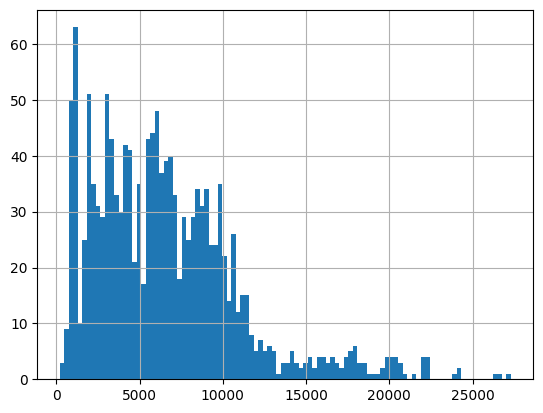

In [149]:
merged_df['distance'].hist(bins=100)

In [154]:
if not DEVELOPMENT:
    dtale.show(merged_df[['customer_geometry', "distance"]])

![alt text](images/customers.png "Title")


In [1187]:
merged_df[['customer_geometry', "distance"]].explore("distance")

In [155]:
books_df.head(2)

,book_id,book_title,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,book_published_year
0,hVFwAAAAQBAJ,Ogilvy on Advertising,['David Ogilvy'],Vintage,2013-09-11,['Social Science'],72.99,320,2013
1,bRY9AAAAYAAJ,Foreign Publications for Advertising American ...,['United States. Bureau of Foreign and Domesti...,['NO_PUBLISHER'],1913-01-01,['Advertising'],469.99,654,1913


In [156]:
books_df[books_df.book_id=='TQpFnkku2poC']

,book_id,book_title,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,book_published_year
36,TQpFnkku2poC,Advertising Management,"['C. L. Tyagi', 'Arun Kumar']",Atlantic Publishers & Dist,2004-01-01,['Advertising'],217.0,790,2004


In [157]:
merged_df.head(2)

,id,patron_id,library_id,date_checkout,date_returned,length,customer_name,customer_street_address,customer_city,customer_state,...,library_name,library_street_address,library_city,library_region,library_postal_code,library_address,library_geometry,library_longitude,library_latitude,distance
0,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14,Jeanette Nelms,4942 SE 28TH AVE,PORTLAND,OREGON,...,MULTNOMAH COUNTY LIBRARY WOODSTOCK,6008 SE 49TH AVE,PORTLAND,OR,97206,"6008 SE 49TH AVE, PORTLAND, OR",POINT (-13649117.262 5697248.904),-122.61210650846269,45.47900505,3066.751994
1,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,62,Melvin Jackson,2821 NE KLICKITAT ST,PORTLAND,OREGON,...,MULTNOMAH COUNTY LIBRARY,205 NE RUSSELL ST,PORTLAND,OR,97212,"205 NE RUSSELL ST, PORTLAND, OR",POINT (-13654840.942 5707125.540),-122.6635232,45.5411809,3130.805100


In [158]:
merged_df = merged_df.rename(columns={
    'id': 'book_id'
})

In [159]:
merged_df = merged_df.merge(books_df, on='book_id', how='left')

In [160]:
merged_df.head(2)

,book_id,patron_id,library_id,date_checkout,date_returned,length,customer_name,customer_street_address,customer_city,customer_state,...,library_latitude,distance,book_title,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,book_published_year
0,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14,Jeanette Nelms,4942 SE 28TH AVE,PORTLAND,OREGON,...,45.47900505,3066.751994,Indian Financial System 5E,['Khan'],Tata McGraw-Hill Education,2006-06-01,['NO_CATEGORY'],416.99,752,2006
1,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,62,Melvin Jackson,2821 NE KLICKITAT ST,PORTLAND,OREGON,...,45.5411809,3130.805100,Advertising Management,"['C. L. Tyagi', 'Arun Kumar']",Atlantic Publishers & Dist,2004-01-01,['Advertising'],217.00,790,2004


In [1196]:
merged_df.to_pickle('data/merged_df.pickle')
merged_df.to_csv('data/merged_df.csv')

In [162]:
merged_df.shape

(1429, 37)

<Axes: >

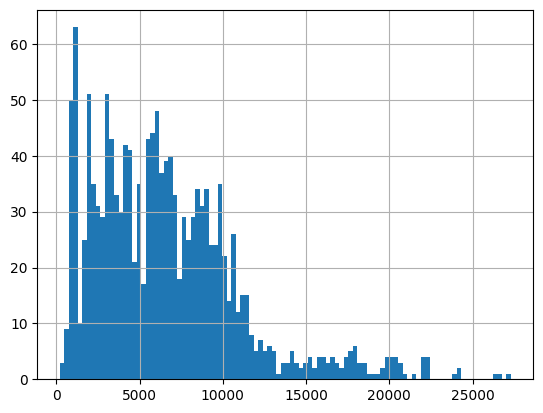

In [163]:
merged_df['distance'].hist(bins=100)

<Axes: >

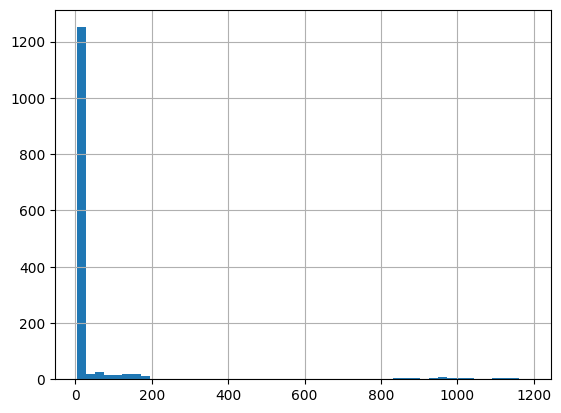

In [1216]:
merged_df['length'].hist(bins=50)

In [164]:
# sns.scatterplot(    x="length",
#                     y="distance",
#                     hue="library_id",
#                     # style="event",
#                     data=late_df)

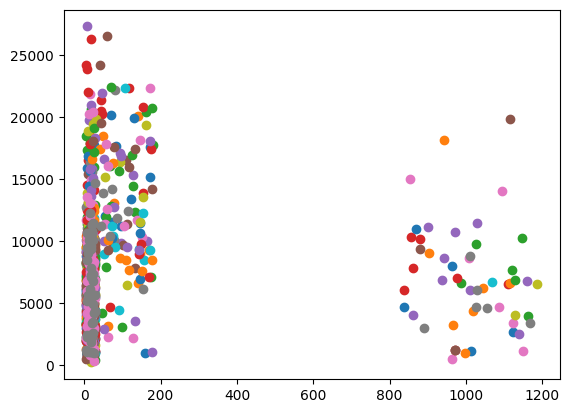

In [165]:
late_df = merged_df[(merged_df['length']<2000)&(merged_df['length']>=0)]
categories = late_df.library_id.unique()

for category in categories:
    subset = late_df[late_df['library_id'] == category]
    plt.scatter(subset['length'], subset['distance'], label=category)



<Axes: xlabel='length', ylabel='distance'>

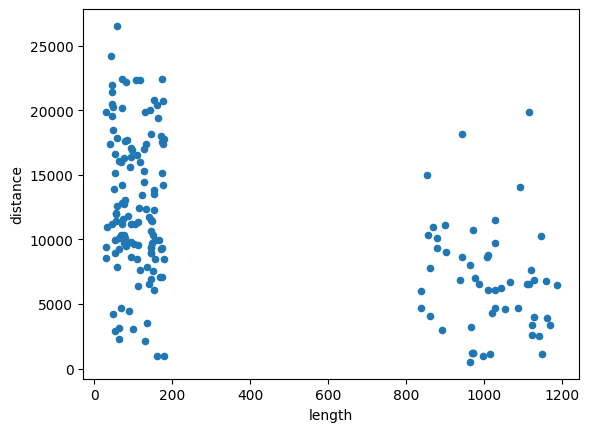

In [166]:
merged_df[(merged_df['length']<2000)&(merged_df['length']>=29)].plot.scatter('length', 'distance')

In [167]:
merged_df[merged_df['length']<29].shape

(1251, 37)

In [168]:
merged_df[merged_df['length']>=29].shape

(178, 37)

In [169]:
merged_df.columns

Index(['book_id', 'patron_id', 'library_id', 'date_checkout', 'date_returned',
       'length', 'customer_name', 'customer_street_address', 'customer_city',
       'customer_state', 'customer_zipcode', 'customer_birth_date',
       'customer_gender', 'customer_education', 'customer_occupation',
       'customer_address', 'customer_geometry', 'customer_longitude',
       'customer_latitude', 'library_name', 'library_street_address',
       'library_city', 'library_region', 'library_postal_code',
       'library_address', 'library_geometry', 'library_longitude',
       'library_latitude', 'distance', 'book_title', 'book_authors',
       'book_publisher', 'book_publishedDate', 'book_categories', 'book_price',
       'book_pages', 'book_published_year'],
      dtype='object')

In [170]:
merged_df.library_id.unique()

array(['223-222@5xc-jxr-tgk', '228-222@5xc-jtz-hwk',
       '23v-222@5xc-jv7-v4v', '22c-222@5xc-jwj-pvz',
       '222-222@5xc-jv5-nt9', '227-222@5xc-jww-btv',
       'zzw-222@5xc-knn-c5z', '224-222@5xc-jw2-t9z',
       'zzw-223@5xc-jv7-ct9', '222-222@5xc-jxp-rp9',
       '222-222@5xc-kkw-bzf', '226-222@5xc-jxj-7yv',
       'zzw-224@5xc-jwv-2rk', '22d-222@5xc-kcy-8sq',
       'zzw-222@5xc-jv4-789', '225-222@5xc-jtz-hkf',
       '226-222@5xc-kc4-fpv', '222-222@5xc-jvf-skf'], dtype=object)

## Most popular libraries

In [171]:
lib_all = merged_df.library_id.value_counts()

lib_all

library_id
222-222@5xc-jv5-nt9    90
zzw-222@5xc-jv4-789    90
223-222@5xc-jxr-tgk    87
222-222@5xc-kkw-bzf    85
zzw-222@5xc-knn-c5z    85
zzw-224@5xc-jwv-2rk    85
225-222@5xc-jtz-hkf    84
226-222@5xc-jxj-7yv    84
22c-222@5xc-jwj-pvz    82
222-222@5xc-jxp-rp9    79
224-222@5xc-jw2-t9z    78
22d-222@5xc-kcy-8sq    78
zzw-223@5xc-jv7-ct9    74
23v-222@5xc-jv7-v4v    74
226-222@5xc-kc4-fpv    70
228-222@5xc-jtz-hwk    69
227-222@5xc-jww-btv    69
222-222@5xc-jvf-skf    66
Name: count, dtype: int64

/home/homoludens/PycharmProjects/ndvi_utils/venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



<Axes: >

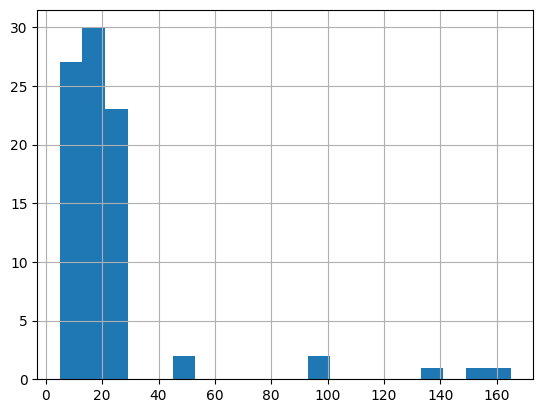

In [1237]:
merged_df[merged_df['length']<200][merged_df.library_id=='222-222@5xc-jv5-nt9']['length'].hist(bins=20)

## Libaraies with most late returns

In [172]:
lib_late = merged_df[(merged_df['length']>28)].library_id.value_counts()
lib_late

library_id
zzw-222@5xc-jv4-789    15
228-222@5xc-jtz-hwk    14
225-222@5xc-jtz-hkf    12
223-222@5xc-jxr-tgk    12
23v-222@5xc-jv7-v4v    12
222-222@5xc-jvf-skf    11
222-222@5xc-jxp-rp9    11
zzw-222@5xc-knn-c5z    11
222-222@5xc-jv5-nt9    10
22c-222@5xc-jwj-pvz    10
zzw-223@5xc-jv7-ct9     9
zzw-224@5xc-jwv-2rk     9
22d-222@5xc-kcy-8sq     9
222-222@5xc-kkw-bzf     8
226-222@5xc-jxj-7yv     8
226-222@5xc-kc4-fpv     7
224-222@5xc-jw2-t9z     5
227-222@5xc-jww-btv     5
Name: count, dtype: int64

In [173]:
lib_late_df = pd.DataFrame(lib_late).reset_index().rename(columns={
    'count' : 'count_late'
})

In [174]:
lib_all_df = pd.DataFrame(lib_all).reset_index().rename(columns={
    'count' : 'count_loans'
})

In [175]:
lib_all_df = lib_all_df.merge(lib_late_df, on='library_id')

In [176]:
lib_all_df['ratio'] = lib_all_df.count_late/lib_all_df.count_loans

In [178]:
lib_all_df.sort_values(by='ratio', ascending=False)

,library_id,count_loans,count_late,ratio
15,228-222@5xc-jtz-hwk,69,14,0.202899
17,222-222@5xc-jvf-skf,66,11,0.166667
1,zzw-222@5xc-jv4-789,90,15,0.166667
13,23v-222@5xc-jv7-v4v,74,12,0.162162
6,225-222@5xc-jtz-hkf,84,12,0.142857
9,222-222@5xc-jxp-rp9,79,11,0.139241
2,223-222@5xc-jxr-tgk,87,12,0.137931
4,zzw-222@5xc-knn-c5z,85,11,0.129412
8,22c-222@5xc-jwj-pvz,82,10,0.121951
12,zzw-223@5xc-jv7-ct9,74,9,0.121622


In [187]:
# libraries_gdf.merge(lib_all_df.sort_values(by='ratio'), on='library_id').sort_values(by='ratio').explore('ratio')

In [186]:
gpd.GeoDataFrame(libraries_gdf.merge(lib_all_df.sort_values(by='ratio'), on='library_id').sort_values(by='ratio')).set_geometry('geometry').explore('ratio', tiles="CartoDB positron", cmap='coolwarm')

In [202]:
lib_late_df

,library_id,count_late
0,zzw-222@5xc-jv4-789,15
1,228-222@5xc-jtz-hwk,14
2,225-222@5xc-jtz-hkf,12
3,223-222@5xc-jxr-tgk,12
4,23v-222@5xc-jv7-v4v,12
5,222-222@5xc-jvf-skf,11
6,222-222@5xc-jxp-rp9,11
7,zzw-222@5xc-knn-c5z,11
8,222-222@5xc-jv5-nt9,10
9,22c-222@5xc-jwj-pvz,10


In [201]:
lib_all_df

,library_id,count_loans,count_late,ratio
0,222-222@5xc-jv5-nt9,90,10,0.111111
1,zzw-222@5xc-jv4-789,90,15,0.166667
2,223-222@5xc-jxr-tgk,87,12,0.137931
3,222-222@5xc-kkw-bzf,85,8,0.094118
4,zzw-222@5xc-knn-c5z,85,11,0.129412
5,zzw-224@5xc-jwv-2rk,85,9,0.105882
6,225-222@5xc-jtz-hkf,84,12,0.142857
7,226-222@5xc-jxj-7yv,84,8,0.095238
8,22c-222@5xc-jwj-pvz,82,10,0.121951
9,222-222@5xc-jxp-rp9,79,11,0.139241


<Axes: xlabel='count_loans', ylabel='count_late'>

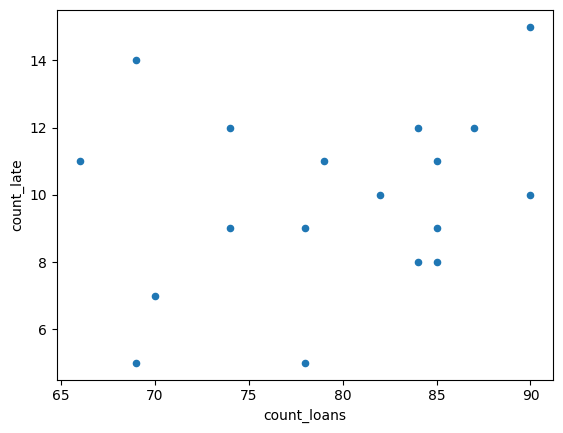

In [203]:
lib_all_df.plot.scatter('count_loans', 'count_late')

# Most popular books

In [204]:
popuplar_books = merged_df.book_id.value_counts()

In [205]:
popular_books_df = pd.DataFrame(merged_df.book_id.value_counts()).reset_index()

In [206]:
books_df.merge(popular_books_df, on='book_id', how='left').sort_values(by='count', ascending=False)[['book_title', 'book_published_year', 'count']].iloc[:10]

,book_title,book_published_year,count
103,Old Dominion Journal of Medicine and Surgery,1904,14
231,Geostatistics for Natural Resources Evaluation,1997,13
150,Effects of Financial Globalization on Developi...,2003,13
238,Technical Report - South Carolina Marine Resou...,1979,13
38,The Mirror Makers,1984,12
9,Negative Political Advertising,2013,12
175,Marine Diesel Engines,2003,11
11,Control of Advertising on Interstate Highways,1957,11
116,The Profit and Loss Account of Modern Medicine...,1915,11
187,A B C of the Steam Engine,1902,11


<Axes: xlabel='book_published_year', ylabel='count'>

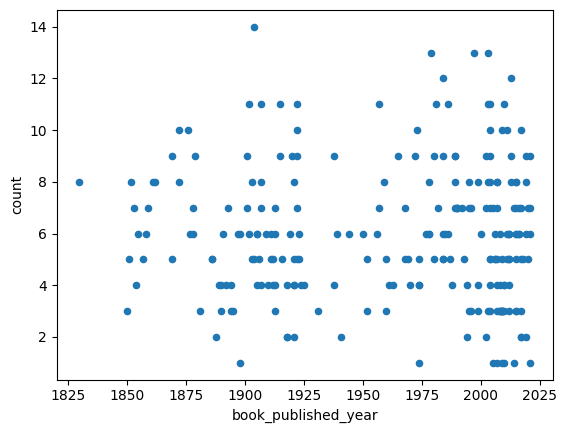

In [207]:
books_df.merge(popular_books_df, on='book_id', how='left').plot.scatter('book_published_year', 'count')

In [196]:
books_merged_df = books_df.merge(popular_books_df, on='book_id', how='left')

In [1286]:
# merged_df[merged_df.book_id=='_L9IAAAAYAAJ'].book_title.iloc[0]

In [1287]:
# merged_df[merged_df.book_id=='CW-7tHAaVR0C'].book_title.iloc[0]

<Axes: xlabel='book_published_year', ylabel='count'>

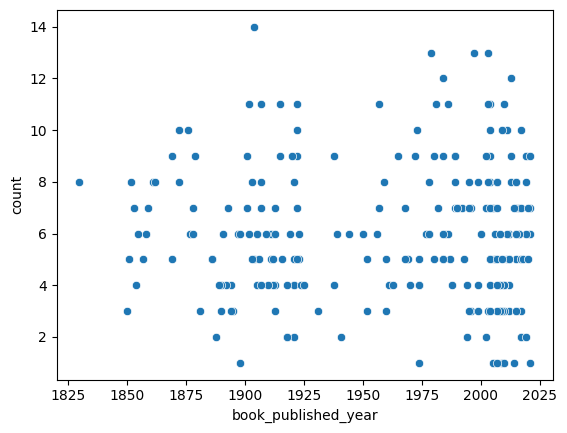

In [208]:
sns.scatterplot(    x="book_published_year",
                    y="count",
                    # hue="library_id",
                    # style="event",
                    data=books_merged_df)

In [ ]:
merged_df.customer_birth_date = pd.to_datetime(merged_df.customer_birth_date)

In [219]:
merged_df['customer_birth_year'] = merged_df.customer_birth_date.dt.year

In [220]:
merged_df['customer_birth_year'].value_counts()

customer_birth_year
1980.0    32
1966.0    31
2000.0    30
2007.0    30
1956.0    29
          ..
1808.0     1
2116.0     1
1811.0     1
1820.0     1
2120.0     1
Name: count, Length: 101, dtype: int64

Now we can calculate book and customer age.

In [221]:
merged_df['book_age'] = (merged_df['date_returned']-merged_df['book_publishedDate']).dt.days/365.25

In [222]:
merged_df['customer_age'] = (merged_df['date_returned']-merged_df['customer_birth_date']).dt.days/365.25

Customers with strange age:

In [223]:
merged_df[(merged_df.customer_age<0)|(merged_df.customer_age>100)].shape

,book_id,patron_id,library_id,date_checkout,date_returned,length,customer_name,customer_street_address,customer_city,customer_state,...,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,book_published_year,customer_birth_year,book_age,customer_age
2,OQ6sDwAAQBAJ,f9372de3c8ea501601aa3fb59ec0f524,23v-222@5xc-jv7-v4v,2018-01-15,2018-04-25,100,James Klein,1720 N SHAVER ST,PORTLAND,OREGON,...,"['Masaaki Okubo', 'Takuya Kuwahara']",Butterworth-Heinemann,2019-08-29,['Technology & Engineering'],190.50,597,2019,2119.0,-1.344285,-100.793977
7,MOewp6bCFfgC,7fd53f66a6d4cd12875487af4008bb08,223-222@5xc-jxr-tgk,2018-04-30,2018-08-30,122,Travis Hardy,636 SE 154TH AVE,PORTLAND,OREGON,...,['United States. Interstate Commerce Commission'],['NO_PUBLISHER'],1981-01-01,['Government publications'],650.99,927,1981,1803.0,37.659138,215.359343
25,Xy5RAAAAYAAJ,f9dea37f4053ade7b6405521b6088a81,22c-222@5xc-jwj-pvz,2018-03-07,2018-03-22,15,Robert Taylor,1923 NE WEIDLER ST,PORTLAND,OREGON,...,['NO_AUTHOR'],['NO_PUBLISHER'],1852-01-01,['Mechanical engineering'],296.99,602,1852,2109.0,166.217659,-91.556468
34,ygoFAAAAQAAJ,7a1f47edd69d69da4c5f95a6a95f75ee,223-222@5xc-jxr-tgk,2018-02-19,2018-03-06,15,Steve Huff,1125 SE 60TH AVE,PORTLAND,OREGON,...,['Ireland commissioners of nat. educ'],['NO_PUBLISHER'],1861-01-01,['NO_CATEGORY'],353.00,658,1861,1806.0,157.171800,212.079398
61,rb8fRXEk0z8C,fe9c2e7610216719ffe58f471c98fa2b,226-222@5xc-jxj-7yv,2018-09-15,2018-10-05,20,Mark Jackson,3969 NE GRAND AVE,PORTLAND,OREGON,...,['NO_AUTHOR'],DIANE Publishing,2021-04-09,['NO_CATEGORY'],271.50,548,2021,1820.0,-2.510609,198.047912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,trqPlpLpjyAC,40a3d490794d2602868149c6c12291b9,228-222@5xc-jtz-hwk,2018-07-23,2018-08-14,22,Mabel McNair,6401 N WILBUR AVE,PORTLAND,OREGON,...,['Batra'],Pearson Education India,2009-01-01,['Advertising'],479.99,514,2009,1806.0,9.615332,212.060233
1401,79QDAAAAMBAJ,49078e95e284448546e38d3e950eeecf,223-222@5xc-jxr-tgk,2018-08-29,2018-09-22,24,Harvey leininger,10744 SE IDLEMAN RD,HAPPY VALLEY,OREGON,...,['NO_AUTHOR'],['NO_PUBLISHER'],1974-05-01,['NO_CATEGORY'],305.99,501,1974,1805.0,44.394251,213.256674
1424,Xy5RAAAAYAAJ,43ecffb93ea5fb7c57d6165a1864fcea,224-222@5xc-jw2-t9z,2018-07-10,2018-08-02,23,Ronald Meza,6025 NE PRESCOTT ST,PORTLAND,OREGON,...,['NO_AUTHOR'],['NO_PUBLISHER'],1852-01-01,['Mechanical engineering'],296.99,602,1852,2114.0,166.581793,-95.882272
1425,rNbuDwAAQBAJ,91871955f3641857832766ac3f5a0b95,222-222@5xc-jv5-nt9,2018-07-19,2018-08-12,24,Brian Ward,35 SE 32ND AVE,PORTLAND,OREGON,...,['Wayland D. Hand'],['NO_PUBLISHER'],2021-01-08,['NO_CATEGORY'],302.00,668,2021,2120.0,-2.409309,-102.034223


In [1399]:
merged_df[(merged_df.customer_age>0)&(merged_df.customer_age<100)].shape

(1224, 41)

<Axes: xlabel='customer_age', ylabel='book_age'>

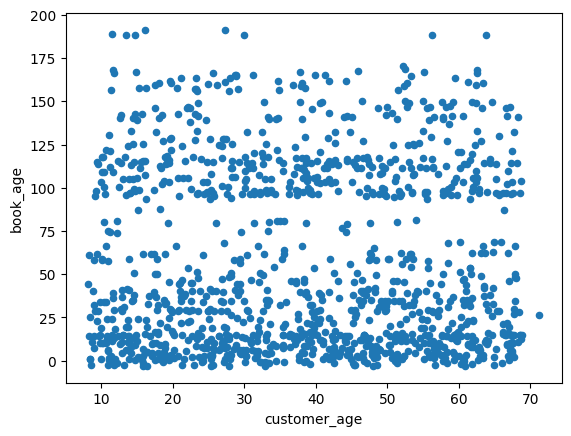

In [224]:
merged_df[(merged_df.customer_age>0)&(merged_df.customer_age<100)].plot.scatter('customer_age','book_age')

<Axes: >

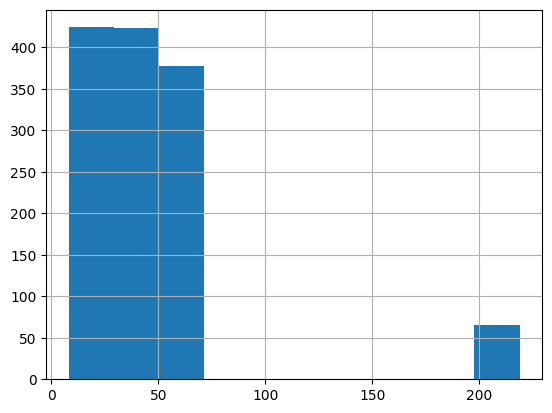

In [225]:
merged_df[merged_df.customer_age>0].customer_age.hist()

Maybe bad data shows less responsible clients:

In [229]:
merged_df[merged_df.customer_age>0]['length'].mean()

62.446082234290145

In [226]:
merged_df[merged_df.customer_age<0]['length'].mean()

49.57575757575758

Not really.

In [230]:
merged_df[(merged_df['length']<2000)&(merged_df['length']>=29)]['customer_birth_year'].value_counts()

customer_birth_year
1959.0    6
1989.0    5
1994.0    5
1957.0    5
2006.0    5
         ..
1814.0    1
1816.0    1
1956.0    1
1988.0    1
1999.0    1
Name: count, Length: 69, dtype: int64

In [231]:
merged_df[(merged_df['length']<2000)]['customer_education'].value_counts()

customer_education
HIGHSCHOOL        367
OTHERS            342
COLLEGE           339
GRADUATEDEGREE    315
NA                 66
Name: count, dtype: int64

In [232]:
merged_df[(merged_df['length']<2000)&(merged_df['length']>=29)]['customer_education'].value_counts()/merged_df[(merged_df['length']<2000)]['customer_education'].value_counts()

customer_education
COLLEGE           0.153392
GRADUATEDEGREE    0.123810
HIGHSCHOOL        0.095368
NA                0.181818
OTHERS            0.116959
Name: count, dtype: float64

# Prepare data for training models

In [233]:
merged_df.columns

Index(['book_id', 'patron_id', 'library_id', 'date_checkout', 'date_returned',
       'length', 'customer_name', 'customer_street_address', 'customer_city',
       'customer_state', 'customer_zipcode', 'customer_birth_date',
       'customer_gender', 'customer_education', 'customer_occupation',
       'customer_address', 'customer_geometry', 'customer_longitude',
       'customer_latitude', 'library_name', 'library_street_address',
       'library_city', 'library_region', 'library_postal_code',
       'library_address', 'library_geometry', 'library_longitude',
       'library_latitude', 'distance', 'book_title', 'book_authors',
       'book_publisher', 'book_publishedDate', 'book_categories', 'book_price',
       'book_pages', 'book_published_year', 'customer_birth_year', 'book_age',
       'customer_age'],
      dtype='object')

    Number variables:
        'length'
        'customer_years_old'
        'distance'
        'customer_age', 
        'book_age'
        'book_price'
        'book_pages'
        
    Category variables:
        'book_categories'
        'customer_gender'
        'customer_education'
        'customer_occupation'
        'book_categories'
        'library_id'
        'customer_zipcode'

    *'book_id', 'patron_id', 'library_id', 
    *'date_checkout', 'date_returned', 
    - 'length', 
    @'customer_name', 
    *'customer_street_address', 'customer_city', 'customer_state', 'customer_zipcode', 
    
    *'customer_birth_date', 'customer_birth_year'
    -'customer_years_old'
    - 'customer_age'
    - 'customer_gender', 
    -'customer_education', 
    -'customer_occupation',
    * 'customer_address', 'customer_geometry', 'customer_longitude', 'customer_latitude', 
    
    - 'library_name',
    * 'library_street_address', 'library_city', 'library_region', 'library_postal_code', 'library_address', 'library_geometry', 'library_longitude', 'library_latitude', 
    - 'distance', 'book_title',
    @'book_authors', @'book_publisher', 
    *'book_publishedDate',
    -'book_categories', 'book_price', 'book_pages', 
    *'book_published_year',
    - 'book_age'

In [236]:
merged_df['library_name'] = merged_df.library_name.apply(lambda x: x.replace('   ', ' ').replace('  ', ' '))

In [238]:
# merged_df.customer_city.value_counts()

In [1418]:
merged_df.book_publisher.value_counts()

book_publisher
['NO_PUBLISHER']              879
Tata McGraw-Hill Education     29
John Wiley & Sons              26
CRC Press                      23
World Bank Publications        20
                             ... 
Lulu.com                        2
UNC Press Books                 2
Gyan Publishing House           1
Policy Press                    1
World Scientific                1
Name: count, Length: 65, dtype: int64

In [1345]:
merged_df.customer_education.unique()

array(['GRADUATEDEGREE', 'HIGHSCHOOL', 'COLLEGE', 'OTHERS', 'NA'],
      dtype=object)

which categories go with others

In [1423]:
for bc in merged_df.book_categories.unique():
    if ',' in bc:
        print(bc)

['Mechanics, Applied']
['Medicine, Naval']
['Natsworthy, Tom (Fictitious character)']
['Mechanics, Analytic']
['Finance, Public']
['Medicine, Preventive']


Most popular categories

In [1421]:
merged_df.book_categories.value_counts()

book_categories
['NO_CATEGORY']             222
['Business & Economics']    183
['Medicine']                103
['Advertising']              81
['Science']                  63
                           ... 
['Accounting']                3
['Mathematics']               2
['Utah']                      2
['History']                   2
['Banking law']               1
Name: count, Length: 88, dtype: int64

<Axes: xlabel='book_published_year', ylabel='length'>

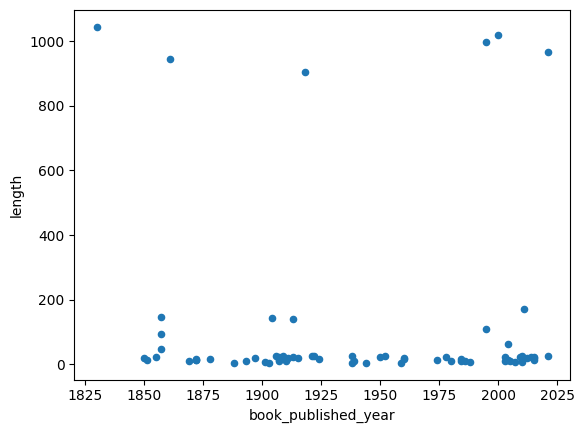

In [1344]:
merged_df[merged_df.library_id=='228-222@5xc-jtz-hwk'].plot.scatter('book_published_year', 'length')

Maybe customer education has something to do with being late

<Axes: xlabel='customer_education', ylabel='length'>

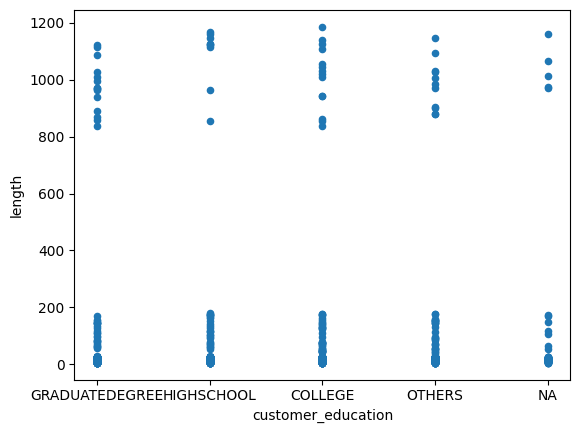

In [240]:
merged_df.plot.scatter('customer_education', 'length')

In [242]:
merged_df['customer_education'].value_counts()

customer_education
HIGHSCHOOL        367
OTHERS            342
COLLEGE           339
GRADUATEDEGREE    315
NA                 66
Name: count, dtype: int64

In [1430]:
# merged_df['length']>28

In [243]:
merged_df['late_return'] = merged_df['length']>28

In [244]:
merged_df.to_pickle('data/merged_df_2.pickle')

# Traing XGBoost model

In [245]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [246]:
label_encoder = LabelEncoder()

In [247]:
data_df = merged_df.copy()

    Number variables:
    'length' - output number
    'customer_years_old'
    'distance'
    'customer_age', 
    'book_age'
    'book_price'
    'book_pages'
    
    Category variables:
    'late_return' - ouput categorical
    'book_categories'




    'customer_gender'
    'customer_education'
    'customer_occupation'
    'book_categories'
    <!-- 'library_name' -->
    'library_id'
    'customer_zipcode'

In [250]:
numerical_variables = [
        # 'length',
    # 'customer_years_old',
    'distance',
    'customer_age', 
    'book_age',
    'book_price',
    'book_pages',
]

categorical_variables = [   
    'late_return',
    'customer_gender',
    'customer_education',
    'customer_occupation',
    'book_categories',
    'library_id',
    'customer_zipcode'
]

for cat_var in categorical_variables:
    data_df[cat_var] = label_encoder.fit_transform(data_df[cat_var])

In [251]:
data_df[numerical_variables+categorical_variables].head()

,distance,customer_age,book_age,book_price,book_pages,late_return,customer_gender,customer_education,customer_occupation,book_categories,library_id,customer_zipcode
0,3066.751994,53.379877,12.030116,416.99,752,0,0,1,7,67,4,17
1,3130.805100,55.222450,15.063655,217.00,790,1,1,1,3,3,10,25
2,3034.316866,-100.793977,-1.344285,190.50,597,1,1,1,6,81,13,38
3,2058.806092,33.524983,21.092402,414.50,561,0,1,1,3,76,11,30
4,5618.204499,41.801506,24.531143,149.00,530,0,1,2,2,22,0,25


In [252]:
data_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   book_id                  1429 non-null   object        
 1   patron_id                1429 non-null   object        
 2   library_id               1429 non-null   int64         
 3   date_checkout            1429 non-null   datetime64[ns]
 4   date_returned            1429 non-null   datetime64[ns]
 5   length                   1429 non-null   int64         
 6   customer_name            1429 non-null   object        
 7   customer_street_address  1429 non-null   object        
 8   customer_city            1429 non-null   object        
 9   customer_state           1429 non-null   object        
 10  customer_zipcode         1429 non-null   int64         
 11  customer_birth_date      1355 non-null   datetime64[ns]
 12  customer_gender          1

In [254]:
X = data_df[numerical_variables+categorical_variables].drop("late_return", axis=1)
y = data_df[numerical_variables+categorical_variables]["late_return"]

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [256]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [257]:
model = xgb.XGBClassifier( use_label_encoder=False, eval_metric='logloss')

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Evaluate XGBoost model

In [258]:
y_pred = model.predict(X_test)

In [259]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8951048951048951
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       256
           1       0.50      0.40      0.44        30

    accuracy                           0.90       286
   macro avg       0.72      0.68      0.69       286
weighted avg       0.89      0.90      0.89       286



In [260]:
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.1048951048951049
R2 Score: -0.1171875


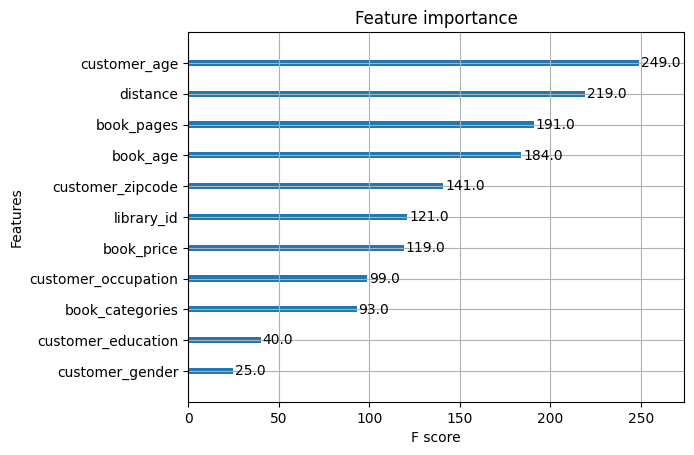

In [262]:
xgb.plot_importance(model)
plt.show()

As expected distance is very important, but customer_age has even higer value. Number of book pages also makes sence, maybe we should suggest different limits based on size of the book?  

Customer zip code is not needed, since that information is even better represented by distance. Education and gender don't have much influence.

# Hyperparameter tuning

In [1503]:

# Define hyperparameters for tuning
param_grid = {
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='logloss'), param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}


In [1505]:
model_hyper = xgb.XGBClassifier( n_estimators=100, max_depth=2, learning_rate= 0.01, use_label_encoder=False, eval_metric='logloss', random_state=42)
model_hyper.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Accuracy: 0.8741258741258742
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       245
           1       0.63      0.29      0.40        41

    accuracy                           0.87       286
   macro avg       0.76      0.63      0.66       286
weighted avg       0.85      0.87      0.85       286

Mean Squared Error: 0.1258741258741259
R2 Score: -0.02498755599800906


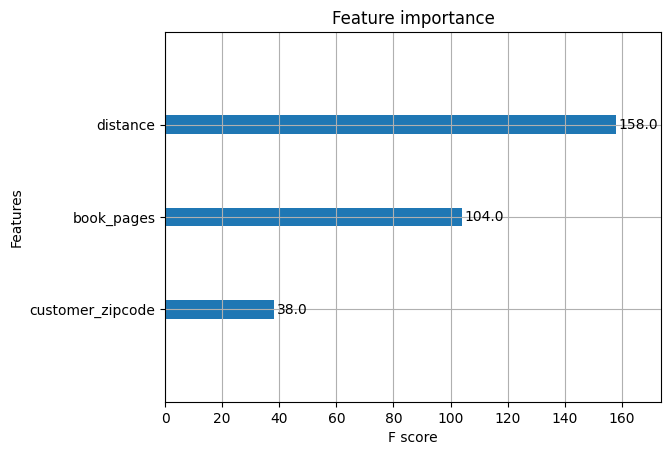

In [1506]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

xgb.plot_importance(model_hyper)
plt.show()

# Regression to estimate days till book return

In [265]:
numerical_variables_r = [
    'length',
    # 'customer_years_old',
    'distance',
    'customer_age', 
    'book_age',
    'book_price',
    'book_pages',
]

categorical_variables_r = [   
    # 'late_return',
    'customer_gender',
    'customer_education',
    'customer_occupation',
    'book_categories',
    'library_id',
    'customer_zipcode'
]

In [266]:
X_r = data_df[numerical_variables_r+categorical_variables_r].drop("length", axis=1)
y_r = data_df[numerical_variables_r+categorical_variables_r]["length"]

X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2)

In [267]:
model = xgb.XGBRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [268]:
y_pred = model.predict(X_test)

Mean Squared Error: 41318.22571124287
R2 Score: -0.22481656074523926


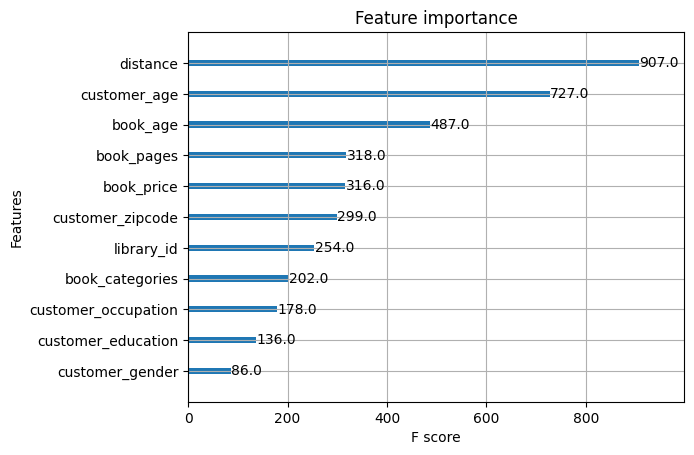

In [269]:
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

xgb.plot_importance(model)
plt.show()

# Using RandomForest

In [270]:
from sklearn.ensemble import RandomForestClassifier

In [272]:
X = data_df[numerical_variables+categorical_variables].drop("late_return", axis=1)
y = data_df[numerical_variables+categorical_variables]["late_return"]

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [274]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [275]:
y_pred = model.predict(X_test)

In [276]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9125874125874126
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       250
           1       0.92      0.33      0.49        36

    accuracy                           0.91       286
   macro avg       0.92      0.66      0.72       286
weighted avg       0.91      0.91      0.89       286



With both XGBoost and Random Forest classifiers prediction is good for determining book will be return on time, but it is less precise on detecting customer will be late. 

Better cleaning of data would help, or just eliminating bad data that we filled, like bad dates, but would reduce training set drasticaly. 

In [284]:
data_clean_df = data_df[~(data_df.customer_age<0)&~(data_df.customer_age>100)].copy()

In [289]:
data_clean_df.head(2)

,book_id,patron_id,library_id,date_checkout,date_returned,length,customer_name,customer_street_address,customer_city,customer_state,...,book_publisher,book_publishedDate,book_categories,book_price,book_pages,book_published_year,customer_birth_year,book_age,customer_age,late_return
0,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,4,2018-05-29,2018-06-12,14,Jeanette Nelms,4942 SE 28TH AVE,PORTLAND,OREGON,...,Tata McGraw-Hill Education,2006-06-01,67,416.99,752,2006,1965.0,12.030116,53.379877,0
1,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,10,2018-11-23,2019-01-24,62,Melvin Jackson,2821 NE KLICKITAT ST,PORTLAND,OREGON,...,Atlantic Publishers & Dist,2004-01-01,3,217.00,790,2004,1963.0,15.063655,55.222450,1


In [286]:
X = data_clean_df[numerical_variables+categorical_variables].drop("late_return", axis=1)
y = data_clean_df[numerical_variables+categorical_variables]["late_return"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [287]:
y_pred = model.predict(X_test)

In [288]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9423076923076923
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       234
           1       1.00      0.42      0.59        26

    accuracy                           0.94       260
   macro avg       0.97      0.71      0.78       260
weighted avg       0.95      0.94      0.93       260



We get much better recall and f1-score when eliminating our dates assumptions.